In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torchvision
from torchvision import datasets, transforms 
import torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import math
import torch.nn.functional as F


from models import Encoder, Decoder
from flows import MAF


In [2]:
bkg_data = torch.load("/eos/user/m/maglowac/Phase2_AD/data_utils/MinBias_with_ID_small.pt").float()[:150_000, 0:100, :]

/tmp/maglowac/ipykernel_898168/1756686711.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bkg_data = torch.load("/eos/user/m/maglowac/Phase2_AD/data_utils/MinBias_with_I

In [3]:
# Apply log to the first column of the last dimension, ignoring zero-padding
logged_bkg_data = bkg_data.clone()  # Create a clone to keep the original data unchanged
first_column = logged_bkg_data[:, :, 0]  # Extract the first column

# Apply np.log where the values are non-zero
mask = first_column != 0  # Mask for non-zero values
first_column[mask] = np.log(first_column[mask])  # Apply log only to non-zero entries

# Save the modified first column back
bkg_data[:, :, 0] = first_column

In [12]:
class BkgDataset(Dataset):
    def __init__(self, data, num_pid_classes):
        self.data = data[:, :, 0:3]
        self.pid = data[:, :, 3].long()  # Ensure PID is integer
        self.num_pid_classes = num_pid_classes
        # Create the mask where the first column is non-zero
        self.mask = (data[:, :, 0] != 0).float()  # Shape: [samples, seq_length]

    def __len__(self):
        return self.data.size(0)  # Number of samples

    def __getitem__(self, idx):
        # One-hot encode the PID
        one_hot_pid = F.one_hot(abs(self.pid[idx]), num_classes=self.num_pid_classes).float()
        return {
            "kin": self.data[idx],       # Kinematic features
            "pid": one_hot_pid,          # One-hot encoded PID
            "mask": self.mask[idx]       # Mask for valid entries
        }

# Create the dataset
dataset = BkgDataset(bkg_data, 300)

# Create the Data

batch_size = 256  # Define batch size
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [13]:
class NormalizingFlowModel(nn.Module):

    def __init__(self, prior, flows):
        super().__init__()
        self.prior = prior
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m).cuda()
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def inverse(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m).cuda()
        for flow in self.flows[::-1]:
            z, ld = flow.inverse(z)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,))
        x, _ = self.inverse(z)
        return x

In [14]:
class DeepsetSetVAE(nn.Module):
    def __init__(self, hparams):
        super(DeepsetSetVAE, self).__init__()
        self.hparams = hparams
        self.encoder = Encoder(d_kin=hparams['d_kin'], d_pid=hparams['d_pid'], use_pid=hparams['use_pid'], d_latent=hparams['d_latent']) 
        self.decoder = Decoder(d_pid=hparams['d_pid'], use_pid=hparams['use_pid'], d_latent=hparams['d_latent'])  
        self.angular_scale = hparams['angular_scale']
    
        # MAF parameters
        self.latent_dim = hparams['d_latent']
        self.maf_hidden_size = hparams.get('maf_hidden_size', 64)
        self.num_maf_layers = hparams.get('num_maf_layers', 5)
        self.normalizing_flow = MAF(self.latent_dim, self.maf_hidden_size)
        flow_init = MAF(dim=self.latent_dim)
        flows_init = [flow_init for _ in range(self.num_maf_layers)]
        prior = torch.distributions.MultivariateNormal(torch.zeros(self.latent_dim).cuda(), torch.eye(self.latent_dim).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z0 = mu + eps * std
        return z0
    
    def forward(self, x, pid, mask):
        # Run Encoder and get NF params
        mu, log_var = self.encoder(x, pid, mask)
    
        z = self.reparameterize(mu, log_var)
 
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF

        #z_k, _, sum_ladj = self.flows(z)

     
        kl_div = (kl_div / x.size(0)) #- sum_ladj.mean()  # mean over batch
        
        kl_div = torch.clamp(kl_div, min=0, max=10.0)
        # Run Decoder
        x_prime = self.decoder(z, pid, mask)
        return x_prime, kl_div, mu, log_var



In [15]:
def l2_loss(x, y, angular_scale):
    """
    Compute L2 loss in spherical coordinates, which is defined as 
    |pT' - pT|^2 - pT^2 * [(eta - eta')^2 + (phi - phi')^2] / R_0^2
    """
    return (
        (x[..., 0] - y[..., 0]).square() +
        x[..., 0].square() * ((x[..., 1:3] - y[..., 1:3]) / angular_scale).square().sum(-1)
    )

def reco_loss(x_recon, x, pid, mask, angular_scale=0.15, use_pid=True):
    """
    Compute Chamfer loss between reconstructed and original particles,
    optionally accounting for PID.
    """
    

    pid = pid.argmax(-1)
    valid_indices = mask.bool()  # (batch_size, seq_len)
    x_recon_masked = x_recon[valid_indices]  # (n_valid, d_output)
    x_masked = x[valid_indices]              # (n_valid, d_output)
    pid_masked = pid[valid_indices]          # (n_valid,) - PID after masking

    # Compute pairwise distances
    dist_mat = l2_loss(
        x_recon_masked.unsqueeze(1),  # (n_valid, 1, d_output)
        x_masked.unsqueeze(0),        # (1, n_valid, d_output)
        angular_scale=angular_scale
    )  # (n_valid, n_valid)

    if use_pid:
        # Mask distances where PIDs do not match
        pid_mismatch_mask = pid_masked.unsqueeze(1) != pid_masked.unsqueeze(0)  # (n_valid, n_valid)
        dist_mat[pid_mismatch_mask] = dist_mat.max().item() + 1

    # Compute forward and backward Chamfer distances
    forward_dist, _ = torch.min(dist_mat, dim=1)  # (n_valid,)
    backward_dist, _ = torch.min(dist_mat, dim=0)  # (n_valid,)

    # Compute average Chamfer loss
    chamfer_loss = (forward_dist.mean() + backward_dist.mean()) / 2

    return chamfer_loss



'''
def reco_loss(x_recon, x_input, pid, mask, angular_scale):
    """
    Compute reconstruction loss between `x_recon` and `x_input` based on the L2 distance in spherical coordinates.
    """
    # Ensure mask is a Boolean tensor
    mask = mask.bool()  # Converts mask to Boolean type if not already

    # Process mask and weights
    weights = mask.float() / mask.float().sum(1, keepdim=True)  # Normalized weights

    # Apply mask to `x_recon` and `x_input`
    x_recon = x_recon.clone()
    x_input = x_input[:, :x_recon.shape[1]]  # Adjust `x_input` to match `x_recon` shape
    x_recon.masked_fill_(~mask[:, :, None], 0)
    x_input.masked_fill_(~mask[:, :, None], 0)

    # Compute pairwise distance matrix
    dist_mat = l2_loss(
        x_recon[:, :, None],  # (batch_size, seq_len, 1, d_output)
        x_input[:, None, :],  # (batch_size, 1, seq_len, d_output)
        angular_scale
    )

    # Mask invalid distances (non-matching particles or invalid indices)
    pid = pid.argmax(-1)  # Get the most likely PID
    dist_mat.masked_fill_(
        ~(mask[:, :, None] & mask[:, None, :]) | (pid[:, :, None] != pid[:, None, :]),
        dist_mat.max().item() + 1  # Large value to exclude invalid distances
    )

    # Compute forward and backward Chamfer distances
    forward_dist = torch.amin(dist_mat, dim=2)  # Minimum distance for each reconstructed particle
    backward_dist = torch.amin(dist_mat, dim=1)  # Minimum distance for each original particle

    # Weighted sum of distances
    loss = 0.5 * weights * (forward_dist + backward_dist)

    # Aggregate losses per sample
    return loss.sum(dim=1)  # Shape: (batch_size,)

'''


'\ndef reco_loss(x_recon, x_input, pid, mask, angular_scale):\n    """\n    Compute reconstruction loss between `x_recon` and `x_input` based on the L2 distance in spherical coordinates.\n    """\n    # Ensure mask is a Boolean tensor\n    mask = mask.bool()  # Converts mask to Boolean type if not already\n\n    # Process mask and weights\n    weights = mask.float() / mask.float().sum(1, keepdim=True)  # Normalized weights\n\n    # Apply mask to `x_recon` and `x_input`\n    x_recon = x_recon.clone()\n    x_input = x_input[:, :x_recon.shape[1]]  # Adjust `x_input` to match `x_recon` shape\n    x_recon.masked_fill_(~mask[:, :, None], 0)\n    x_input.masked_fill_(~mask[:, :, None], 0)\n\n    # Compute pairwise distance matrix\n    dist_mat = l2_loss(\n        x_recon[:, :, None],  # (batch_size, seq_len, 1, d_output)\n        x_input[:, None, :],  # (batch_size, 1, seq_len, d_output)\n        angular_scale\n    )\n\n    # Mask invalid distances (non-matching particles or invalid indices)\

In [16]:
def vae_loss(x_recon, x_input, pid, kl_div, mask, angular_scale, beta):
    # Reconstruction loss
    reconstruction_loss = reco_loss(x_recon, x_input, pid, mask, angular_scale)

    reco_scale = 1 * (1 - beta)

    loss = (reconstruction_loss * reco_scale) + (beta * kl_div)

    return loss, reconstruction_loss, kl_div


In [17]:
hparams = {
    "model": DeepsetSetVAE,
    "d_kin": 3,
    "d_pid": 300,
    "use_pid": True,
    "d_model": 64,
    "d_latent": 16,  # Increased latent dimensionality
    "d_ff": 128,
    "d_output": 3,
    "n_encoder_layers": 4,
    "n_decoder_layers": 4,
    "maf_hidden_size": 8,
    "num_maf_layers": 5,
    "dropout": 0.,
    "beta": 0.01,  # Start with a small nonzero beta
    "angular_scale": 0.15,
    "lr": 0.0005,  # Reduced learning rate
    "batch_size": 256,
    "warmup": 100,
    "patience": 10,
    "factor": 1.0,
    "soft_kl_steps": 5000,  # Faster KL annealing
    "latent_reg_weight": 0.1
}


In [18]:
def covariance_regularization(z):
    """
    Computes variance-covariance regularization loss.
    Promotes a diagonal covariance matrix to encourage diverse representations.
    """
    batch_size, latent_dim = z.size()
    z_centered = z - z.mean(dim=0, keepdim=True)  # Center latent vectors
    cov_matrix = (z_centered.T @ z_centered) / batch_size  # Covariance matrix
    diag_cov = torch.diag(cov_matrix)  # Diagonal elements
    off_diag_cov = cov_matrix - torch.diag_embed(diag_cov)  # Off-diagonal elements

    variance_loss = torch.mean((diag_cov - 1) ** 2)  # Encourage unit variance
    covariance_loss = torch.mean(off_diag_cov ** 2)  # Penalize off-diagonal terms
    return variance_loss + covariance_loss

In [19]:
import torch.optim as optim

# Instantiate the model
model = DeepsetSetVAE(hparams)
model.train()

# Move model to device (CPU or GPU)
device = torch.device('cuda')
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=hparams['lr'])

# Scheduler (if needed)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=hparams['patience'], gamma=hparams['factor'])

# Training parameters
num_epochs = 100  # Adjust as needed
global_step = 0

for epoch in range(num_epochs):
    for batch in train_loader:  # Assume train_loader provides batches of data
        global_step += 1
        # Extract data from batch and move to device
        kin = batch['kin'].to(device)    # Shape: (batch_size, seq_len, d_kin)
        mask = batch['mask'].to(device)  # Shape: (batch_size, seq_len)
        pid = batch['pid'].to(device)

        beta = hparams['beta']
        # Forward pass
        x_recon, kl_div, mu, log_var = model(kin, pid, mask)
        # Compute losse
        loss, reconstruction_loss, kl_divergence = vae_loss(x_recon, kin, pid, kl_div, mask, hparams['angular_scale'], beta)

        #latent_regularization_loss = covariance_regularization(mu)
        #loss += hparams['latent_reg_weight'] * latent_regularization_loss
        # Soft KL annealing
        hparams['beta']
        if hparams['soft_kl_steps'] > 0:
            kl_weight = min(1.0, global_step / hparams['soft_kl_steps'])
            beta = hparams['beta'] * kl_weight

        
        #print(reconstruction_loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Learning rate warmup
        if global_step < hparams['warmup']:
            lr_scale = float(global_step) / float(max(1, hparams['warmup']))
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * hparams['lr']

    # Scheduler step (if using scheduler)
    scheduler.step()

    torch.save(model.state_dict(), 'VAE_NF.pth')
    # Logging
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Recon Loss: {reconstruction_loss.mean().item():.4f}, KL Loss: {kl_divergence.mean().item():.4f}, Beta: {beta:.6f}")

    # Validation and early stopping logic can be added here


Epoch [1/100], Loss: 0.2323, Recon Loss: 0.2340, KL Loss: 0.0677, Beta: 0.001172
Epoch [2/100], Loss: 0.2256, Recon Loss: 0.2274, KL Loss: 0.0499, Beta: 0.002344
Epoch [3/100], Loss: 0.2224, Recon Loss: 0.2245, KL Loss: 0.0155, Beta: 0.003516
Epoch [4/100], Loss: 0.2202, Recon Loss: 0.2221, KL Loss: 0.0256, Beta: 0.004688
Epoch [5/100], Loss: 0.2220, Recon Loss: 0.2237, KL Loss: 0.0517, Beta: 0.005860
Epoch [6/100], Loss: 0.2259, Recon Loss: 0.2280, KL Loss: 0.0178, Beta: 0.007032


In [81]:
torch.save(model.state_dict(), 'VAE_NF.pth')

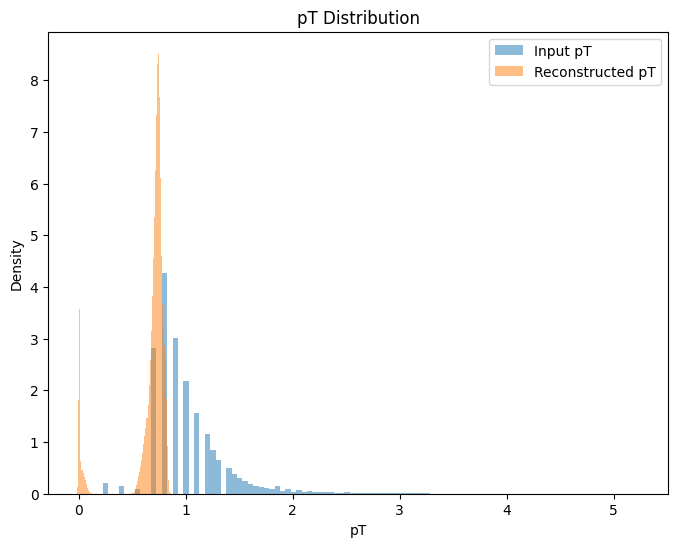

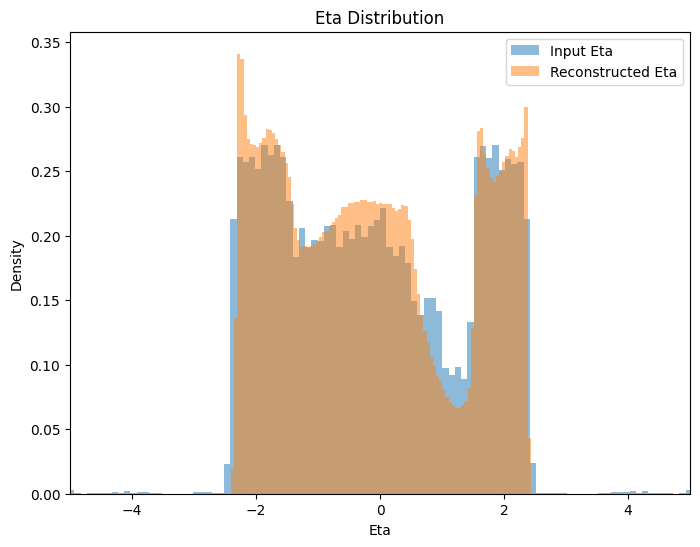

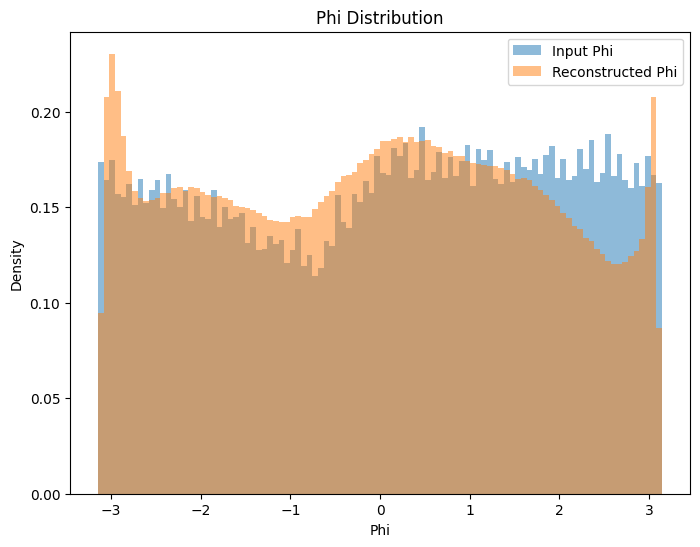

In [96]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import mean_absolute_error

# Set the model to evaluation mode
model.eval()

# Initialize lists to collect kinematic features
pt_input_list = []
eta_input_list = []
phi_input_list = []

pt_recon_list = []
eta_recon_list = []
phi_recon_list = []

device = torch.device('cuda')

with torch.no_grad():
    for batch in train_loader:  # Assume train_loader provides batches of data

        # Extract data from batch and move to device
        kin = batch['kin'].to(device)    # Shape: (batch_size, seq_len, d_kin)
        mask = batch['mask'].to(device)  # Shape: (batch_size, seq_len)
        pid = batch['pid'].to(device)

        # Forward pass
        x_recon, mu, logvar, log_det_jacobian = model(kin, pid, mask)

        # Move tensors to CPU and convert to numpy arrays
        x_input_np = kin.cpu().numpy()
        x_recon_np = x_recon.cpu().numpy()
        mask_np = mask.cpu().numpy()

        # Flatten the arrays
        x_input_flat = x_input_np.reshape(-1, 3)
        x_recon_flat = x_recon_np.reshape(-1, 3)
        mask_flat = mask_np.flatten()

        # Select valid (non-masked) particles
        valid_indices = mask_flat == 1

        x_input_valid = x_input_flat[valid_indices]
        x_recon_valid = x_recon_flat[valid_indices]

        # Extract kinematic features
        pt_input_list.append(x_input_valid[:, 0])
        eta_input_list.append(x_input_valid[:, 1])
        phi_input_list.append(x_input_valid[:, 2])

        pt_recon_list.append(x_recon_valid[:, 0])
        eta_recon_list.append(x_recon_valid[:, 1])
        phi_recon_list.append(x_recon_valid[:, 2])

# Concatenate lists to get arrays
pt_input_all = np.concatenate(pt_input_list)
eta_input_all = np.concatenate(eta_input_list)
phi_input_all = np.concatenate(phi_input_list)

pt_recon_all = np.concatenate(pt_recon_list)
eta_recon_all = np.concatenate(eta_recon_list)
phi_recon_all = np.concatenate(phi_recon_list)


# Handle phi wrapping
phi_input_all = (phi_input_all + np.pi) % (2 * np.pi) - np.pi
phi_recon_all = (phi_recon_all + np.pi) % (2 * np.pi) - np.pi

# Plotting function
def plot_histogram(input_data, recon_data, feature_name, bins=100, log_scale=False, range=None, xlim=False):
    plt.figure(figsize=(8, 6))
    plt.hist(input_data, bins=bins, alpha=0.5, label=f'Input {feature_name}', density=True, range=range)
    plt.hist(recon_data, bins=100, alpha=0.5, label=f'Reconstructed {feature_name}', density=True, range=range)
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.legend()
    plt.title(f'{feature_name} Distribution')
    if log_scale:
        plt.yscale('log')
    if xlim:
        plt.xlim(-5,5)
    plt.show()

# Plot pT
plot_histogram(pt_input_all, pt_recon_all, 'pT', bins=100, log_scale=False, xlim=False)

# Plot eta
plot_histogram(eta_input_all, eta_recon_all, 'Eta', bins=100, xlim=True)

# Plot phi
plot_histogram(phi_input_all, phi_recon_all, 'Phi', bins=100, range=(-np.pi, np.pi))

# Compute and print MAE
#mae_pt = mean_absolute_error(pt_input_all, pt_recon_all)
#mae_eta = mean_absolute_error(eta_input_all, eta_recon_all)
#phi_diff = np.angle(np.exp(1j * (phi_input_all - phi_recon_all)))
#mae_phi = np.mean(np.abs(phi_diff))

#print(f'Mean Absolute Error for pT: {mae_pt:.4f}')
#print(f'Mean Absolute Error for eta: {mae_eta:.4f}')
#print(f'Mean Absolute Error for phi: {mae_phi:.4f}')


In [11]:
def plot_histogram(input_data, recon_data, feature_name, bins=100, log_scale=False, range=None, xlim=False):
    plt.figure(figsize=(8, 6))
    plt.hist(input_data, bins=bins, alpha=0.5, label=f'Input {feature_name}', density=True, range=range)
    plt.hist(recon_data, bins=bins, alpha=0.5, label=f'Reconstructed {feature_name}', density=True, range=range)
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.legend()
    plt.title(f'{feature_name} Distribution')
    if log_scale:
        plt.yscale('log')
    if xlim:
        plt.xlim(0,10)
    plt.show()

In [ ]:
plot_histogram(pt_input_all, pt_recon_all, 'pT', bins=100, log_scale=False, xlim=True)

In [ ]:
# Plot pT
plot_histogram(pt_input_all, pt_recon_all, 'pT', bins=50, log_scale=False)

# Plot eta
plot_histogram(eta_input_all, eta_recon_all, 'Eta', bins=100)

# Plot phi
plot_histogram(phi_input_all, phi_recon_all, 'Phi', bins=100, range=(-np.pi, np.pi))

# Compute and print MAE
mae_pt = mean_absolute_error(np.exp(pt_input_all), np.exp(pt_recon_all))
mae_eta = mean_absolute_error(eta_input_all, eta_recon_all)
phi_diff = np.angle(np.exp(1j * (phi_input_all - phi_recon_all)))
mae_phi = np.mean(np.abs(phi_diff))

print(f'Mean Absolute Error for pT: {mae_pt:.4f}')
print(f'Mean Absolute Error for eta: {mae_eta:.4f}')
print(f'Mean Absolute Error for phi: {mae_phi:.4f}')

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage:
encoder = Encoder(d_kin=hparams['d_kin'], d_pid=hparams['d_pid'], use_pid=hparams['use_pid'], d_latent=hparams['d_latent']) 
num_params = count_parameters(encoder)
print(f"Number of trainable parameters: {num_params}")